In [64]:
from tensorflow import keras
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [65]:
dataset = pd.read_csv("../Datasets/ENB2012_data.csv")
dataset = shuffle(dataset)
delta = 1
x_test = dataset.iloc[:50,:]
x_test = dataset.iloc[:50,:]
x_train = dataset.iloc[50:,:]
y_train = x_train.iloc[:,-2:]
y_test = x_test.iloc[:,-2:]
x_train = x_train.iloc[:,:-2]
x_test = x_test.iloc[:,:-2]
x_train_dummy = pd.get_dummies(x_train.iloc[:,-1])
x_test_dummy = pd.get_dummies(x_test.iloc[:,-1])
x_train['0'] = x_train_dummy.iloc[:,0]
x_train['1'] = x_train_dummy.iloc[:,1]
x_train['2'] = x_train_dummy.iloc[:,2]
x_train['3'] = x_train_dummy.iloc[:,3]
x_train['4'] = x_train_dummy.iloc[:,4]
x_train['5'] = x_train_dummy.iloc[:,5]
x_train.pop('X8')
x_test['0'] = x_test_dummy.iloc[:,0]
x_test['1'] = x_test_dummy.iloc[:,1]
x_test['2'] = x_test_dummy.iloc[:,2]
x_test['3'] = x_test_dummy.iloc[:,3]
x_test['4'] = x_test_dummy.iloc[:,4]
x_test['5'] = x_test_dummy.iloc[:,5]
x_test.pop('X8')

657    3
427    3
94     1
247    5
383    2
234    4
187    3
569    1
19     0
488    5
426    3
590    2
405    3
720    5
622    2
65     1
729    5
670    3
109    2
393    3
86     1
200    4
759    5
120    2
341    2
736    5
386    3
273    5
356    2
275    5
51     1
5      0
256    5
547    1
7      0
123    2
596    2
217    4
364    2
292    1
163    3
665    3
249    5
295    1
225    4
198    4
233    4
661    3
182    3
585    2
Name: X8, dtype: int64

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [67]:
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [68]:
def huber_loss(y_true, y_pred, delta):
    loss = keras.losses.huber(y_true=y_true,y_pred=y_pred, delta=delta)
    return loss

In [69]:
def EnergyEff():
    model = models.Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(1,activation=keras.activations.softsign))
    model.compile(loss=lambda y_true, y_pred:huber_loss(y_true, y_pred, delta),  optimizer='SGD')
    return model

In [70]:
lrs = []
K1 = 0.
epochs = 2000
batch_size=64
num_classes = 2

In [71]:
model_const = EnergyEff() 
K.set_value(model_const.optimizer.learning_rate, 0.1)
history = model_const.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(x_test, y_test))

In [72]:
model_adapt = EnergyEff()
func = K.function([model_adapt.layers[0].input], [model_adapt.layers[-2].output])
def lr_schedule(epoch):
    global K1

    Kz = 0.
    
    for i in (range((len(x_train) - 1) // batch_size + 1)):
      start_i = i * batch_size
      end_i = start_i + batch_size
      xb = x_train[start_i:end_i]
    
      tmp = np.array(func([xb]))
      activ = np.linalg.norm(tmp)
      
      if activ > Kz:
          Kz = activ
    K1 = (1/batch_size)*(Kz)*(1/num_classes)*(1/delta)
    lr = 1 / K1
    lrs.append(lr)
    return lr


In [73]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [74]:
history_lalr=model_adapt.fit(x_train, y_train, epochs = epochs, verbose=0, batch_size = batch_size,validation_data=(x_test,y_test),callbacks=[lr_scheduler])

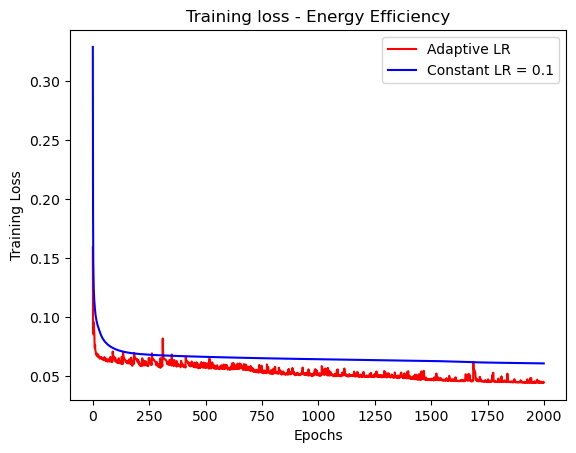

In [75]:
loss_adaptive = history_lalr.history['loss']
loss_constant = history.history['loss']
epochs = range(len(loss_adaptive))
plt.plot(epochs, loss_adaptive, 'r', label='Adaptive LR')
plt.plot(epochs, loss_constant, 'b',label='Constant LR = 0.1')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training loss - Energy Efficiency')
plt.legend()


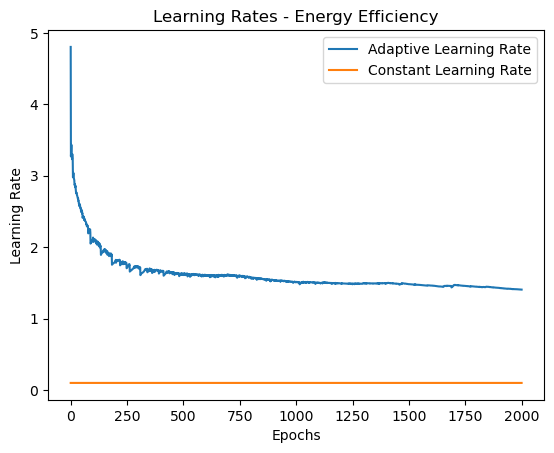

In [77]:
plt.title('Learning Rates - Energy Efficiency')
plt.plot(epochs, lrs, label='Adaptive Learning Rate')
plt.plot(epochs, [0.1]*len(epochs), label ='Constant Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()

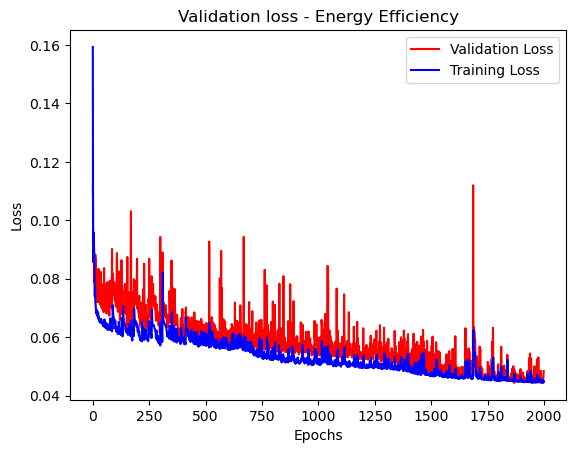

In [81]:
val_loss = history_lalr.history['val_loss']
loss = history_lalr.history['loss']
epochs = range(len(loss_adaptive))

plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.plot(epochs, loss, 'b',label="Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.plot(epochs, history_lalr, 'b', label='LALR')
plt.title('Validation loss - Energy Efficiency')
plt.legend()